This example aims to have two target orbits, and one observer orbit. The observer is tasked with monitoring the two targets to minimize the trace covariance of the state over the simulation horizon. We use a PPO agent that is rewarded for minimizing the trace covariance of the target states to the best of its ability.

In [1]:
%matplotlib widget
import sys
sys.path.append("../src")

import os
import numpy as np
from torch import tensor
import matplotlib.pyplot as plt

from SensorTasking import SpaceEnv
from SensorTasking.observation_model import DummyModel, ApparentMag
from SensorTasking.observation_spaces import Type1, Type2
from SensorTasking import run_myopic_policy

from data_util.target_generation import TargetGenerator


from stable_baselines3 import PPO

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy


In [2]:
# mass parameter of earth-moon system
mu = 1.215058560962404e-02
# apparent magnitude of sun
ms = -26.4
# specular reflection coefficient
aspec = 0
# diffuse reflection coefficient
adiff = 0.2
# diameter of target (LU)
d = 0.001 / 384400
# earth radius (LU)
rearth = 6371 / 384400
# moon radius (LU)
rmoon = 1737.4 / 384400

params = {
    "mu":mu,
    "ms":ms,
    "aspec":aspec,
    "adiff":adiff,
    "d":d,
    "rearth":rearth,
    "rmoon":rmoon
}

# L2 Halo orbit, period = 3.225 TU  (Target orbit)
x0_1 = np.array([
        1.1540242813087864,
        0.0,
        -0.1384196144071876,
        4.06530060663289e-15,
        -0.21493019200956867,
        8.48098638414804e-15
    ])

# L1 lyapunov, period = 3.225 TU (target orbit)
x0_2 = np.array([
        0.8027692908754149,
        0.0,
        0.0,
        -1.1309830924549648e-14,
        0.33765564334938736,
        0.0
    ])


# 1:1 L2 Lyapunov, period = 6.45 TU (observer orbit)
x0_3 = np.array([
        0.9982702689023665,
        0.0,
        0.0,
        -2.5322340091977996e-14,
        1.5325475708886613,
        0.0
    ])



In [3]:
tg = TargetGenerator([x0_1, x0_2], periods=[3.225, 3.225])
ag = TargetGenerator([x0_3], periods = [6.45])

In [4]:
log_dir = "/Users/malavpatel/Research/SensorTasking/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [5]:
# targets = np.array([target1, target2])
targets = tg.gen_phased_ics([1,1], stochastic=True)
agents = ag.gen_phased_ics([1], stochastic=False)
maxsteps = 430
tstep = 0.015
obs_model = ApparentMag(params, tstep, sun_phasing=np.pi/2)
obs_class = Type1()
policytype = "MultiInputPolicy"

env = SpaceEnv(agents, targets, obs_model, maxsteps, tstep, obs_class=obs_class)
env = Monitor(env, log_dir)

check_env(env)

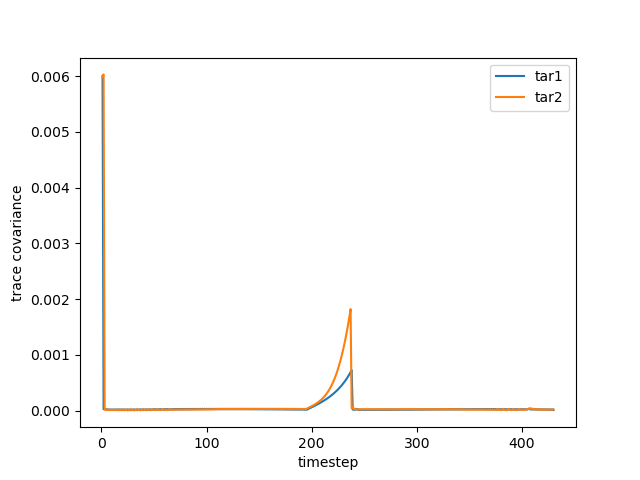

In [6]:
obs, info = env.reset()
terminated = False
tr_covs = np.zeros(shape=(2, maxsteps))

cum_reward = 0

index = 0
while not terminated:
    most_uncertain_target, uncertainty = (1, 0)

    for i, kalman_object in enumerate(env.kalman_objects):
        tar_uncertainty = np.trace(kalman_object.P)
        tr_covs[i, index] = tar_uncertainty
        

        if tar_uncertainty > uncertainty:
            most_uncertain_target, uncertainty = (i+1, tar_uncertainty)

    obs, reward, terminated, tmp, info = env.step(most_uncertain_target)

    cum_reward += reward
    index += 1

tt = np.arange(1, maxsteps + 1)
plt.figure()
plt.plot(tt,tr_covs[0,:], label = "tar1")
plt.plot(tt,tr_covs[1,:], label = "tar2")
plt.xlabel("timestep")
plt.ylabel("trace covariance")
plt.legend()


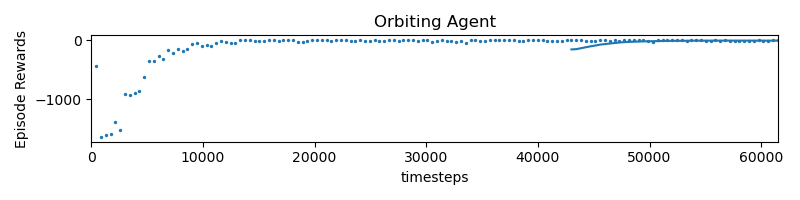

In [7]:
model = PPO(policytype, env, gamma=0.7, seed=32, verbose=0)
model.learn(total_timesteps=int(6e4))
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Orbiting Agent"
)

In [8]:
tar1cov = []
tar2cov = []
tar1apmag = []
tar2apmag = []
actions = []
prev_actions = []
tar1 = []
tar2 = []
tar2_avail = []
tt = np.arange(1, maxsteps+1)
def actlogprob(locals, globals):
        model = locals["model"]
        env = locals["env"]

        tar1cov.append(model.get_env().env_method("get_info")[0]["target1_cov"])
        tar2cov.append(model.get_env().env_method("get_info")[0]["target2_cov"])

        tar1apmag.append(model.get_env().env_method("get_info")[0]["target1_obs1_apmag"])
        tar2apmag.append(model.get_env().env_method("get_info")[0]["target2_obs1_apmag"])

        actions.append(model.get_env().get_attr("prev_action")[0])
        prev_actions.append(model.get_env().get_attr("prev_available_actions")[0])

        tar1.append(model.get_env().env_method("get_observation")[0]["target1_state"][:3])
        tar2.append(model.get_env().env_method("get_observation")[0]["target2_state"][:3])

        tar2_avail.append(model.get_env().get_attr("obs_model")[0].is_visible(env.get_attr("kalman_objects")[0][1], env.get_attr("observers")[0]))

evaluate_policy(model, env, deterministic=False, return_episode_rewards=True, n_eval_episodes=1, callback=actlogprob)

([-0.308071], [430])

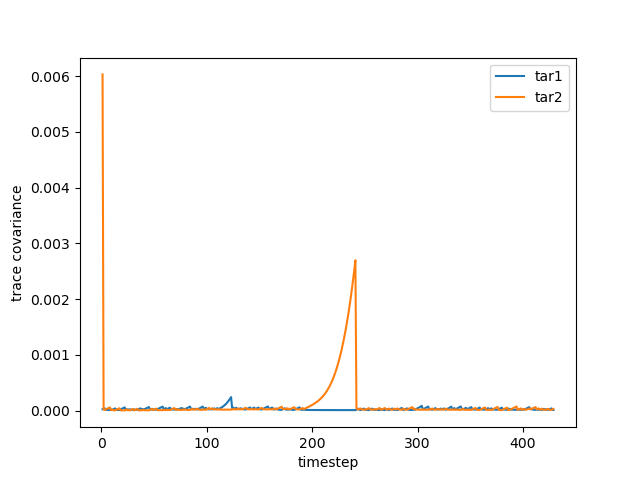

In [9]:
plt.figure()
plt.plot(tt[:-1],tar1cov[:-1], label = "tar1")
plt.plot(tt[:-1],tar2cov[:-1], label = "tar2")
plt.xlabel("timestep")
plt.ylabel("trace covariance")
plt.legend()

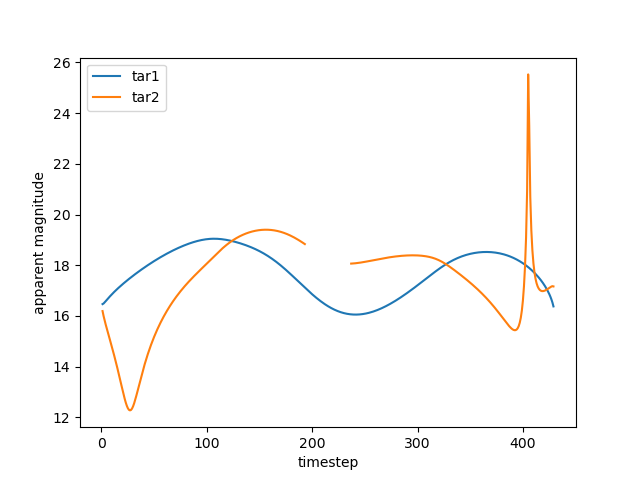

In [10]:
plt.figure()
plt.plot(tt[:-1],tar1apmag[:-1], label = "tar1")
plt.plot(tt[:-1],tar2apmag[:-1], label = "tar2")
plt.xlabel("timestep")
plt.ylabel("apparent magnitude")
plt.legend()

Text(0, 0.5, 'action')

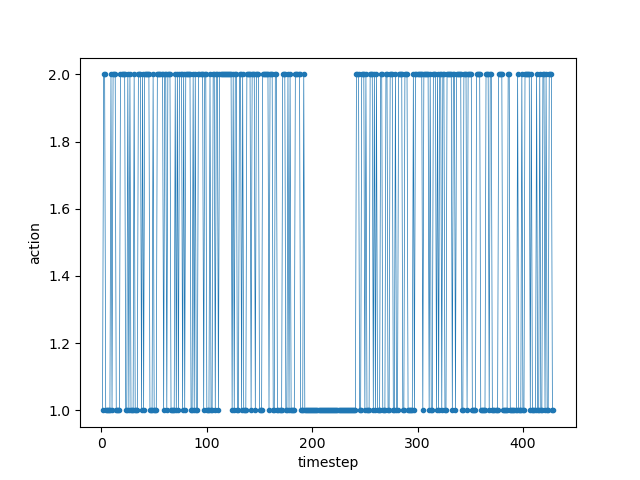

In [11]:
plt.figure()
plt.plot(tt[:-1], actions[:-1], marker='.', linewidth = 0.5)
plt.xlabel("timestep")
plt.ylabel("action")

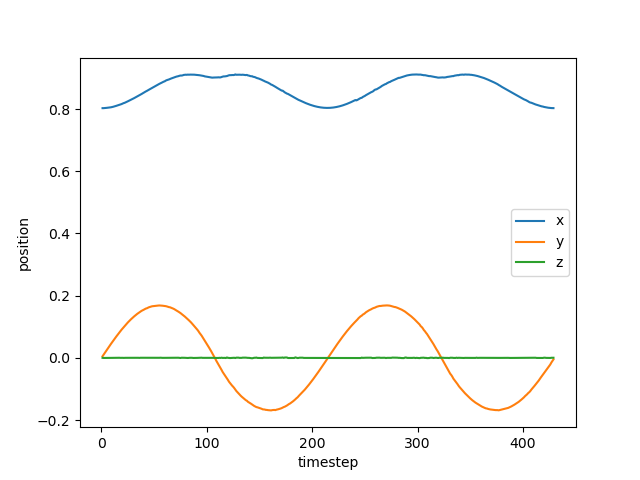

In [12]:
plt.figure()
plt.xlabel("timestep")
plt.ylabel("position")
plt.plot(tt[:-1], tar2[:-1], label = ["x", "y", "z"])
plt.legend()

In [13]:
430 - np.where(np.array(actions[:-1]) == 0)[0].size

430